In [1]:
import tensorflow as tf
import tensorflow.contrib.layers as layers
import numpy as np
import matplotlib.pyplot as plt

import sys
sys.path.insert(0, '/Users/zgubic/Projects/FairMass/fairmass')
import plotting

# Generate the data

according to:

x ~ N((0,0), [[1, -0.5],[-0.5, 1]]) when Y == 0

x ~ N((1,1+z), [[1,0],[0,1]]) when Y == 1

where Z has a Gaussian prior z ~ N(0,1)

/Users/zgubic/anaconda3/envs/tf/lib/python3.6/site-packages/matplotlib/figure.py:445: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


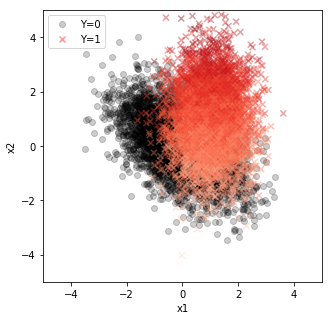

In [2]:
# generate variates
def generate(n_samples, z=None):
    Y = np.zeros(n_samples)
    Y[n_samples//2:] = 1

    if z == None:
        Z = np.random.normal(0, 1, size=n_samples)
    else:
        Z = z * np.ones(n_samples)

    X0 = np.random.multivariate_normal([0, 0], [[1, -0.5],[-0.5, 1]], size=n_samples//2)
    X1 = np.random.multivariate_normal([1, 1], 0.5*np.eye(2), size=n_samples//2)
    X1[:,1] += Z[n_samples//2:]
    X = np.concatenate([X0, X1])
    return X, Y, Z

def plot_variates(X, Y, Z):
    n_samples = X.shape[0]
    fig, ax = plt.subplots(figsize=(5,5))
    ax.scatter(X[Y==0,0], X[Y==0,1], marker='o', color='k', alpha=0.2, label='Y=0')
    ax.scatter(X[Y==1,0], X[Y==1,1], marker='x', c=Z[n_samples//2:], alpha=0.4, cmap='Reds', label='Y=1')
    ax.set_ylim(-5, 5)
    ax.set_xlim(-5, 5)
    ax.set_xlabel('x1')
    ax.set_ylabel('x2')
    leg = ax.legend(loc='best')
    leg.legendHandles[1].set_color('red')
    fig.show()
    
n_samples = 10000
X, Y, Z = generate(n_samples)
plot_variates(X, Y, Z)

# Train a classifier without the adversary

Trains a classifier f(X) that gives p(f(X)) which depends on Z, i.e. p(f(X)|Z=z). 

In [3]:
def classifier(x_in, name):
    
    with tf.variable_scope(name):
        
        # define the output of the network
        dense1 = layers.relu(x_in, 20)
        dense2 = layers.relu(dense1, 20)
        output = layers.linear(dense2, 1)

    these_vars = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, scope=name)
    
    return output, these_vars

def classifier_loss(clf_output, y_in):
    
    # define the loss and optimisation steps
    y_shaped = tf.reshape(y_in, shape=(n_samples, 1))
    loss_D = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(labels=y_shaped, logits=clf_output))
    
    return loss_D

def train_classifier(sess, opt_D, loss_D, x_in, y_in, z_in, generate, n_samples, n_epochs):
    
    # train it
    losses = []
    
    for epoch in range(n_epochs):
        X, Y, Z = generate(n_samples)
        feed_dict = {x_in:X, y_in:Y, z_in:Z}
        _, l_D = sess.run([opt_D, loss_D], feed_dict=feed_dict)
        losses.append(l_D)
        
    # plot the losses
    fig, ax = plt.subplots()
    ax.plot(range(len(losses)), losses, c='k', label='classifier loss (L_D)')
    ax.set_xlabel('epochs')
    ax.set_ylabel('classifier loss (L_D)')
    ax.legend(loc='best')
    ax.set_title('Classifier Loss (L_D)')
    plt.show()
    
    return None

Do the actual training

In [4]:
sess = tf.InteractiveSession()
ctr = 0

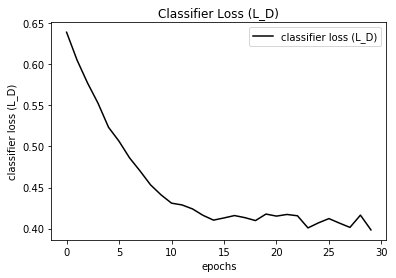

/Users/zgubic/anaconda3/envs/tf/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6510: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")
/Users/zgubic/anaconda3/envs/tf/lib/python3.6/site-packages/matplotlib/figure.py:445: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


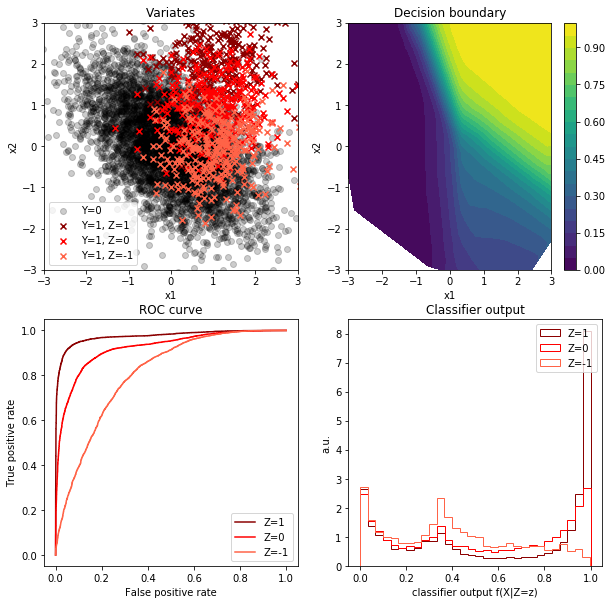

In [5]:
n_samples = 10000
n_epochs = 30
ctr+=1
name = 'name'+str(ctr)
    
# input placeholders
x_in = tf.placeholder(tf.float32, shape=[n_samples, 2], name='X1_X2')
y_in = tf.placeholder(tf.float32, shape=[n_samples, ], name='Y')
z_in = tf.placeholder(tf.float32, shape=[n_samples, ], name='Z')

# create the classifier graph, loss, and optimisation
clf_output, vars_D = classifier(x_in, name)
loss_D = classifier_loss(clf_output, y_in)
opt_D = tf.train.AdamOptimizer(learning_rate=0.01).minimize(loss_D, var_list=vars_D)

# train the classifier
sess.run(tf.global_variables_initializer())
train_classifier(sess, opt_D, loss_D, x_in, y_in, z_in, generate, n_samples, n_epochs)

# plot the performance of the classifier
plotting.plot_classifier_performance(x_in, y_in, clf_output, generate, sess)

# Adversarial training

Train adversarially against different losses.

In [30]:
def adversary_pdf(clf_output, n_components, name):
    
    with tf.variable_scope(name):
        
        # define the output of a network (depends on number of components)
        dense1 = layers.relu(clf_output, 20)
        dense2 = layers.relu(dense1, 20)
        output_noact = layers.linear(dense2, 3*n_components)
        print(output_noact)
        
        # make sure sigmas are positive and pis are normalised 
        mu = output_noact[:, :n_components]
        sigma = tf.exp(output_noact[:, n_components:2*n_components])
        pi = tf.nn.softmax(output_noact[:, 2*n_components:])
        
        # and merge them together again
        output = tf.concat([mu, sigma, pi], axis=1)
    
    these_vars = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, scope=name)
    
    return output, these_vars

def loss_adversary_pdf(z_in, adv_output):
    
    # build the pdf (max likelihood principle)
    mu = adv_output[:, :n_components]
    sigma = adv_output[:, n_components:2*n_components]
    pi = adv_output[:, 2*n_components:]
    
    pdf = 0
    for c in range(n_components):
        pdf += pi[:, c] * ((1. / np.sqrt(2. * np.pi)) / sigma[:, c] *
                tf.math.exp(-(z_in - mu[:, c]) ** 2 / (2. * sigma[:, c] ** 2)))
            
    # make the loss
    nll = - tf.math.log(pdf)
    loss_R = tf.reduce_mean(nll)
    
    return loss_R, mu, sigma, pi, pdf, nll

def train_adversary(sess, opt_R, loss_R, x_in, y_in, z_in, generate, n_samples, n_epochs, debug):

    # unpack debug
    mu, sigma, pi, pdf, nll = debug
    
    # train it
    losses = []
    
    for epoch in range(n_epochs):
        X, Y, Z = generate(n_samples)
        feed_dict = {x_in:X, y_in:Y, z_in:Z}
        _, l_R, m, s, p, PDF, NLL = sess.run([opt_R, loss_R, mu, sigma, pi, pdf, nll], feed_dict=feed_dict)
        #print('mu', m)
        #print('sigma', s)
        #print('pi', p)
        #print('pdf', PDF)
        #print('nll', NLL)
        #print('loss', l_R)
        losses.append(l_R)
        
    # plot the losses
    fig, ax = plt.subplots()
    ax.plot(range(len(losses)), losses, c='k', label='adversary loss (L_D)')
    ax.set_xlabel('epochs')
    ax.set_ylabel('adversary loss (L_R)')
    ax.legend(loc='best')
    ax.set_title('Adversary Loss (L_R)')
    plt.show()
    
    return None

Tensor("name16_adv/fully_connected_2/BiasAdd:0", shape=(10000, 15), dtype=float32)
Tensor("name16_adv/strided_slice:0", shape=(10000, 5), dtype=float32)
Tensor("name16_adv/Exp:0", shape=(10000, 5), dtype=float32)
Tensor("name16_adv/Softmax:0", shape=(10000, 5), dtype=float32)
Tensor("name16_adv/concat:0", shape=(10000, 15), dtype=float32)


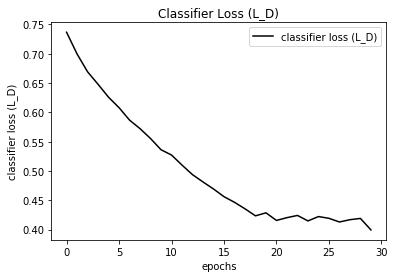

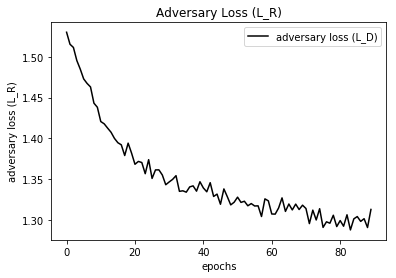

In [32]:
n_samples = 10000
n_epochs = 30
n_components = 5
ctr+=1
name = 'name'+str(ctr)
    
# input placeholders
x_in = tf.placeholder(tf.float32, shape=[n_samples, 2], name='X12')
y_in = tf.placeholder(tf.float32, shape=[n_samples, ], name='Y')
z_in = tf.placeholder(tf.float32, shape=[n_samples, ], name='Z')

# create the classifier graph, loss, and optimisation
clf_output, vars_D = classifier(x_in, name+'_clf')
loss_D = classifier_loss(clf_output, y_in)
opt_D = tf.train.AdamOptimizer(learning_rate=0.01).minimize(loss_D, var_list=vars_D)

# create the adversary graph, loss, and optimisation
adv_output, vars_R = adversary_pdf(clf_output, n_components, name+'_adv')
loss_R, mu, sigma, pi, pdf, nll = loss_adversary_pdf(z_in, adv_output)
opt_R = tf.train.AdamOptimizer(learning_rate=0.001).minimize(loss_R, var_list=vars_R)

# create the combined loss function (for the classifier)
loss_DR = 

# initialise the variables
sess.run(tf.global_variables_initializer())

# pretrain the classifier
train_classifier(sess, opt_D, loss_D, x_in, y_in, z_in, generate, n_samples, n_epochs)

# pretrain the adversary
debug = [mu, sigma, pi, pdf, nll]
train_adversary(sess, opt_R, loss_R, x_in, y_in, z_in, generate, n_samples, 3*n_epochs, debug)

# now do the adversarial part (modifed loss function for the classifier)


# plot the performance of the classifier
#plotting.plot_classifier_performance(x_in, y_in, clf_output, generate, sess)
